In [1]:
import numpy,sys,matplotlib
import scanpy,velocyto

# 1. Visualization

/Users/alomana/anaconda3/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../anaconda3/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/alomana/anaconda3/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back 

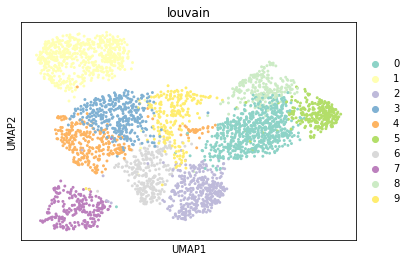

In [2]:
idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')
adata=idata.transpose()

scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

adata.obs['n_counts'] = adata.X.sum(axis=1)

scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

adata.raw = adata

scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
adata = adata[:, adata.var['highly_variable']]

scanpy.pp.regress_out(adata, ['n_counts'])
scanpy.pp.scale(adata, max_value=10)

scanpy.tl.pca(adata,svd_solver='arpack')
scanpy.pp.neighbors(adata,n_neighbors=12,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata,color=['louvain'],palette='Set3')

In [3]:
cell_cluster_map=adata.obs['louvain'].to_dict()
cells_barcodes_per_day={}
barcodes=[]
for element in list(cell_cluster_map.keys()):
    day_label=element.split('.')[1]
    barcode=element.split('_M397')[0]
    barcodes.append(barcode)
    if day_label not in cells_barcodes_per_day:
        cells_barcodes_per_day[day_label]=[barcode]
    else:
        cells_barcodes_per_day[day_label].append(barcode)

print(adata)
print(len(barcodes))
unique_barcodes=list(set(barcodes))
print(len(unique_barcodes))
print(cells_barcodes_per_day.keys())
print(cells_barcodes_per_day['control'][:10])

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
3477
3471
dict_keys(['control', 'day3', 'day6', 'day13', 'day17', 'day24'])
['AAACCTGCAAGAGGCT', 'AAACGGGTCATTCACT', 'AAAGATGAGTCCAGGA', 'AAAGATGCACTTACGA', 'AAAGATGGTGCCTGGT', 'AACCGCGTCTCAAACG', 'AACGTTGAGGGATACC', 'AACGTTGTCTCGTTTA', 'AACTCAGTCACATACG', 'AACTCCCTCTCGCATC']


# 2. Velocity analysis

In [4]:
vlm=velocyto.VelocytoLoom("/Volumes/omics4tb2/alomana/projects/mscni/results/velocyto/combined.loom")

In [5]:
sample_rosetta={}
sample_rosetta['20765_M397_control']='control'
sample_rosetta['21729_day3']='day3'
sample_rosetta['21766_day6']='day6'
sample_rosetta['22077_day13']='day13'
sample_rosetta['22152_day17']='day17'
sample_rosetta['18324_Yapeng_single_cell']='day24'

selected_cells=[]
all_cells=vlm.ca['CellID']

for cellID in all_cells:
    day_label=sample_rosetta[cellID.split(':')[0]]
    barcode=cellID.split(':')[1].replace('x','')
    
    if barcode in cells_barcodes_per_day[day_label]:
        selected_cells.append(cellID)
        
mask=numpy.isin(vlm.ca['CellID'],selected_cells)
print(mask,mask.shape)
    
print(vlm.ca['CellID'].shape[0])
print(vlm.ca['CellID'])
vlm.filter_cells(bool_array=mask)
print(vlm.ca['CellID'].shape[0])

[False  True False ... False False  True] (7396,)
7396
['20765_M397_control:AAGACCTCAGGTCCACx'
 '20765_M397_control:AACTCAGTCACATACGx'
 '20765_M397_control:AAATGCCAGGCTCTTAx' ...
 '18324_Yapeng_single_cell:TTTGTCAAGTATCGAAx'
 '18324_Yapeng_single_cell:TTGGAACCATCGATGTx'
 '18324_Yapeng_single_cell:TTTACTGCAATCAGAAx']
3477


In [6]:
# don't forget to set cluster names

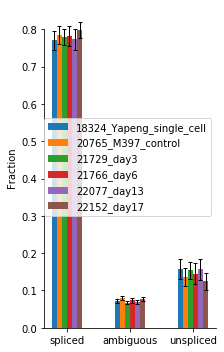

In [7]:
vlm.plot_fractions()

In [8]:
vlm.normalize("S",size=True,log=True)
vlm.normalize("U",size=True,log=False)

In [9]:
vlm.score_detection_levels()
vlm.filter_genes(by_detection_levels=True)

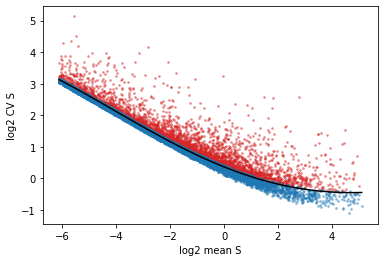

In [10]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [11]:
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

In [12]:
number_of_cells=vlm.ca['CellID'].shape[0]
nei=int(0.025*number_of_cells)
print(number_of_cells,nei)

3477 86


In [13]:
vlm.perform_PCA(n_components=50)
vlm.knn_imputation(k=nei,n_pca_dims=50,balanced=True,n_jobs=1)

In [14]:
vlm.fit_gammas()

In [15]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [16]:
positions=adata.obsm['X_umap']
vlm.ts=positions

In [17]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=nei, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

/Users/alomana/anaconda3/lib/python3.7/site-packages/velocyto/analysis.py:1569: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


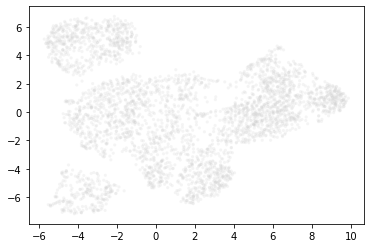

In [18]:
matplotlib.pyplot.scatter(vlm.embedding[:, 0],vlm.embedding[:, 1],c="0.8",alpha=0.2,s=10,edgecolor="")

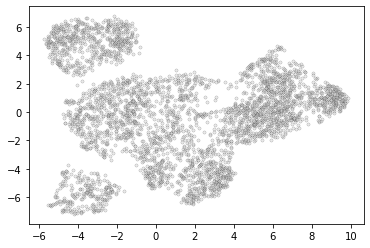

In [19]:
# overlay arrows
ix_choice = numpy.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
matplotlib.pyplot.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)


#quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color='black', alpha=1)
#matplotlib.pyplot.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],**quiver_kwargs)


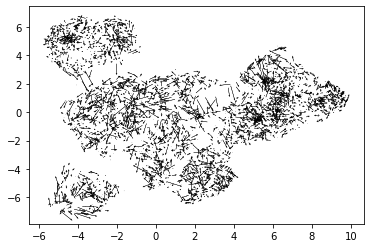

In [20]:
quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color='black', alpha=1)
matplotlib.pyplot.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],**quiver_kwargs)

In [25]:
matplotlib.pyplot.savefig('figure2.pdf')
matplotlib.pyplot.clf()

<Figure size 432x288 with 0 Axes>

In [22]:
matplotlib.pyplot.clf()

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot